# 0. Google CoLab일 경우
 * 아래의 Drive Mount 실행해주기

In [1]:
# My Google Drive Mount하기!
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## 1.3. Fine Tuning

* Load VGG16

In [2]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(
    weights='imagenet', # None으로 줄 경우: Model의 구조만 가져오고 Weights는 안 가져온다.
    include_top=False,
    input_shape=(150, 150, 3)
)

conv_base.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

* Define Model

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

model3 = Sequential()

model3.add(conv_base)
model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


* Load Data

In [4]:
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/drive/MyDrive/03. Kookmin AI Big Data MBA/Semester 3_032021-062021/2. Deep Learning/Jupyter Notebook/data_Week 09/train'
val_dir = '/content/drive/MyDrive/03. Kookmin AI Big Data MBA/Semester 3_032021-062021/2. Deep Learning/Jupyter Notebook/data_Week 09/validation'
test_dir = '/content/drive/MyDrive/03. Kookmin AI Big Data MBA/Semester 3_032021-062021/2. Deep Learning/Jupyter Notebook/data_Week 09/test'

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


* Unfreeze Specific Layers

In [6]:
[layer.name for layer in conv_base.layers]

['input_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool']

* **block5_conv1** 이후부터 모두 Unfreeze한다.

In [7]:
conv_base.trainable = True

IsUnfreezeStart = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        IsUnfreezeStart = True
    if IsUnfreezeStart == True:
        layer.trainable = True
    else:
        layer.trainable = False

* 잘 반영되었는지 확인하기!

In [8]:
[layer.trainable for layer in conv_base.layers]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True]

In [9]:
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


* Fit Model

In [10]:
from tensorflow.keras import optimizers

model3.compile(
    optimizer=optimizers.RMSprop(lr=1e-5),
    loss='binary_crossentropy',
    metrics=['acc']
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:
history3 = model3.fit(
    train_gen,
    steps_per_epoch=100,
    epochs=5,
    validation_data=val_gen,
    validation_steps=50
)

Epoch 1/5
100/100 [==============================] - 823s 8s/step - loss: 0.6888 - acc: 0.5840 - val_loss: 0.5288 - val_acc: 0.7760
Epoch 2/5
100/100 [==============================] - 24s 236ms/step - loss: 0.5881 - acc: 0.6890 - val_loss: 0.3915 - val_acc: 0.8460
Epoch 3/5
100/100 [==============================] - 23s 233ms/step - loss: 0.5143 - acc: 0.7470 - val_loss: 0.3460 - val_acc: 0.8400
Epoch 4/5
100/100 [==============================] - 22s 224ms/step - loss: 0.4435 - acc: 0.7845 - val_loss: 0.2771 - val_acc: 0.8800
Epoch 5/5
100/100 [==============================] - 24s 235ms/step - loss: 0.4154 - acc: 0.8110 - val_loss: 0.2681 - val_acc: 0.8790


In [13]:
model3.save('/content/drive/MyDrive/03. Kookmin AI Big Data MBA/Semester 3_032021-062021/2. Deep Learning/Jupyter Notebook/data_Week 09/cats_and_dogs_small_4.h5')

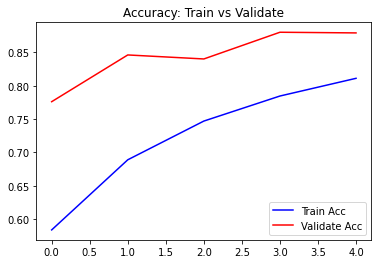

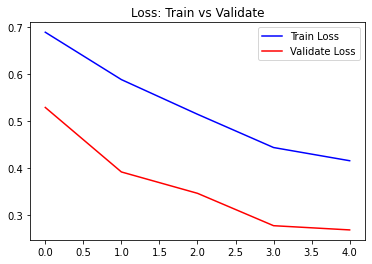

''

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

train_acc = history3.history['acc']
val_acc = history3.history['val_acc']

train_loss = history3.history['loss']
val_loss = history3.history['val_loss']

epoch_list = range(len(train_acc))

plt.plot(epoch_list, train_acc, 'b', label='Train Acc')
plt.plot(epoch_list, val_acc, 'r', label='Validate Acc')
plt.title('Accuracy: Train vs Validate')
plt.legend()

plt.figure()

plt.plot(epoch_list, train_loss, 'b', label='Train Loss')
plt.plot(epoch_list, val_loss, 'r', label='Validate Loss')
plt.title('Loss: Train vs Validate')
plt.legend()

plt.show()
;

In [20]:
def MakeCurveSmooth(arr, factor=0.8):

    smoothed_arr = []

    for point in arr:

        if smoothed_arr:
            previouspoint = smoothed_arr[-1]
            smoothed_arr.append(previouspoint * factor + point * (1 - factor))
        else:
            smoothed_arr.append(point)

    return smoothed_arr

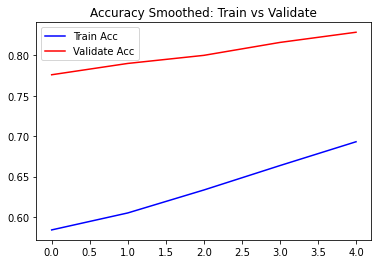

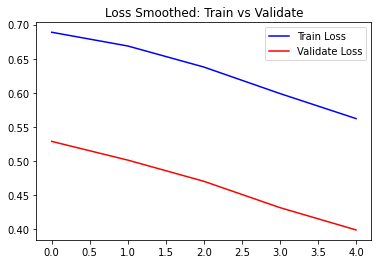

''

In [21]:
plt.plot(epoch_list, MakeCurveSmooth(train_acc), 'b', label='Train Acc')
plt.plot(epoch_list, MakeCurveSmooth(val_acc), 'r', label='Validate Acc')
plt.title('Accuracy Smoothed: Train vs Validate')
plt.legend()

plt.figure()

plt.plot(epoch_list, MakeCurveSmooth(train_loss), 'b', label='Train Loss')
plt.plot(epoch_list, MakeCurveSmooth(val_loss), 'r', label='Validate Loss')
plt.title('Loss Smoothed: Train vs Validate')
plt.legend()

plt.show()
;

* Test Set에 대해 Evaluate해보자!

In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1/255.0
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

test_loss, test_acc = model3.evaluate(test_gen, steps=50)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)